In [1]:

import csv
from six import StringIO
import tempfile
import numpy as np

from tensor2tensor.data_generators import problem
from tensor2tensor.layers import common_layers
from tensor2tensor.models import transformer
from tensor2tensor.utils import registry
from tensor2tensor.utils import t2t_model

from tensor2tensor.data_generators import generator_utils
from tensor2tensor.data_generators import text_problems
from tensor2tensor.utils import metrics

import tensorflow as tf

import tk

from tk.models import similarity_transformer
from tk.data_generators import function_docstring

from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()
Modes = tf.estimator.ModeKeys


# Multi-problem, single network experiment

Here we'll experiment with a problem that mixes the two in-painting example types, using the same network to solve both problems. This is towards training a single encoder that can later be used for both doc strings and code, circumventing the need to specifically train code and doc strings to be embedded into the same space.


## Problem definition

In [2]:

def _random_mask_sequence(sequence):
  """'quick brown fox' -> 'quick ##### fox'"""
  arr = sequence.split()
  ind = np.random.randint(len(arr))
  arr[ind] = ''.join(["#" for _ in range(0, len(arr[ind]))])
  return ' '.join(arr)


In [7]:

# TODO: Could yield with certain probabilities to control abundance
# TODO: In-paintable region could be of variable size and distribution
# TODO: Do this using preprocess step instead of generating completely new set of examples?

@registry.register_problem
class GithubMultiProblemBase(function_docstring.GithubFunctionDocstring):
  """Code in-painting given randomly ablated regions."""

  def generate_samples(self, data_dir, tmp_dir, dataset_split):
    csv_files = self.get_csv_files(data_dir, tmp_dir, dataset_split)

    for pairs_file in csv_files:
      tf.logging.debug("Reading {}".format(pairs_file))
      with tf.gfile.Open(pairs_file) as csv_file:
        for line in csv_file:
          reader = csv.reader(StringIO(line))
          for docstring_tokens, function_tokens in reader:

            yield {
                "inputs": _random_mask_sequence(function_tokens),
                "targets": function_tokens,
                "embed_code": [0]
            }

            yield {
                "inputs": _random_mask_sequence(docstring_tokens),
                "targets": docstring_tokens,
                "embed_code": [0]
            }


In [ ]:

tmp_dir = "/mnt/nfs-east1-d/tmp"
data_dir = "/mnt/nfs-east1-d/data"
multi_problem = GithubMultiProblemBase()
multi_problem.generate_data(data_dir, tmp_dir)


## Training

In [9]:

from tk.experiment import configure_experiment, T2TExperiment

args = configure_experiment("cs-multi1",
                             problem="github_multi_problem_base",
                             hparams_set="transformer_tiny",
                             model="transformer",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=10000)

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'transformer_tiny',
 'log_device_placement': False,
 'model': 'transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-multi1/cs-multi1-j1014-1845-b89f/output',
 'problem': 'github_multi_problem_base',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-multi1/cs-multi1-j1014-1845-b89f/tk',
 'train_steps': 10000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-14 19:08:24,352] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-10-14 19:08:25,466] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-14 19:08:25,891] Finished loading event data for comparison.


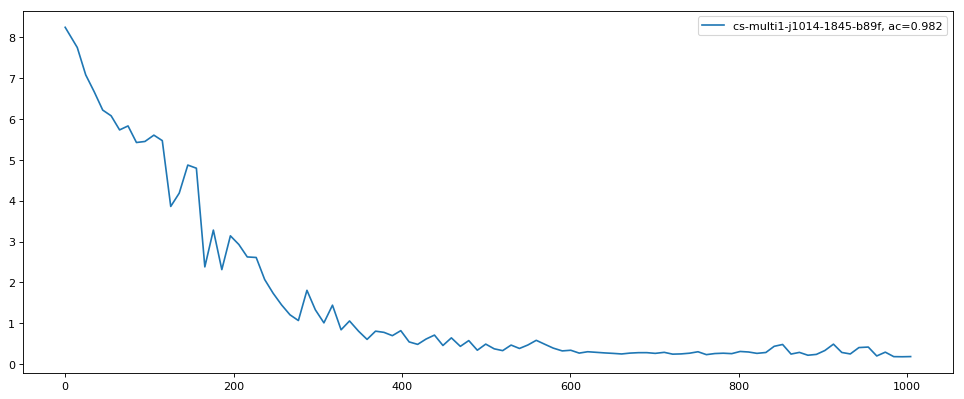

In [2]:

#from tk.allen_demo import event_data_for_comparison, show_experiment_loss
#%matplotlib inline

experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-multi1*")
show_experiment_loss(experiment_data)


## Alternative model

Hmmm so there's no guarantee pairs will be embedded in a similar way here. But it might just happen. But if not, can train at the same time to produce corresponding embeddings...

This supposes our examples are of the form: 

```python
{
    "inputs": "some input, e.g. masked code",
    "targets": "some corresponding target, e.g. unmasked code",
    "docstring": "a docstring to embed",
    "code": "code to embed"
}
```

where the inputs/targets pair is only masked docstring/docstring or masked code/code for the sake of simplicity of implementation. if we only do one at a time instead of both then we can just return the tensor produced by super(Transformer, self).body() instead of having to manually call self.loss.


In [3]:

from tensor2tensor.models.transformer import Transformer
from tk.models.similarity_transformer import similarity_cost

@registry.register_model
class ConstrainedEmbeddingTransformer(Transformer):

  def body(self, features):
    hparams = self._hparams
    target_space = problem.SpaceID.EN_TOK

    if self._hparams.mode == tf.estimator.ModeKeys.PREDICT:
      return self.encode(features["predictme"], target_space, hparams,
                         features=features), {"training": 0.0}

    string_embedding, _ = self.encode(features["docstring"], target_space, hparams,
                                      features=features) # Not sure if this last will work
    code_embedding, _ = self.encode(features["code"], target_space, hparams,
                                    features=features)
    sc = similarity_cost(string_embedding, code_embedding, self.hparams.loss_variant)

    ret = super(Transformer, self).body(features)

    if len(ret) == 2:
      if not isinstance(ret[1], dict):
        raise ValueError("Unexpected second type in superclass body return.")
      ret[1]["similarity"] = sc
      return ret
    return ret, {"similarity": sc}


In [5]:

@registry.register_problem
class GithubConstrainedEmbedding(function_docstring.GithubFunctionDocstring):

  def generate_samples(self, data_dir, tmp_dir, dataset_split):
    csv_files = self.get_csv_files(data_dir, tmp_dir, dataset_split)

    for pairs_file in csv_files:
      tf.logging.debug("Reading {}".format(pairs_file))
      with tf.gfile.Open(pairs_file) as csv_file:
        for line in csv_file:
          reader = csv.reader(StringIO(line))
          for docstring_tokens, function_tokens in reader:

            yield {
                "inputs": _random_mask_sequence(function_tokens),
                "targets": function_tokens,
                "docstring": docstring_tokens,
                "code": function_tokens,
                "embed_code": [0]
            }

            yield {
                "inputs": _random_mask_sequence(docstring_tokens),
                "targets": docstring_tokens,
                "docstring": docstring_tokens,
                "code": function_tokens,
                "embed_code": [0]
            }

  # TODO: This and following methods need fixing.

  def feature_encoders(self, data_dir):
    encoder = self.get_or_create_vocab(data_dir, None, force_get=True)
    encoders = {"targets": encoder}
    encoders["inputs"] = encoder
    encoders["code"] = encoder
    encoders["docstring"] = encoder
    return encoders

  def example_reading_spec(self):
    data_fields, data_items_to_decoders = super(GithubConstrainedEmbedding,
                                                self).example_reading_spec()
    
    data_fields["docstring"] = tf.VarLenFeature(dtype=tf.int64)
    data_fields["code"] = tf.VarLenFeature(dtype=tf.int64)

    data_items_to_decoders.update({
      "code": tf.contrib.slim.tfexample_decoder.Tensor(tensor_key="code"),
      "docstring": tf.contrib.slim.tfexample_decoder.Tensor(tensor_key="docstring")
    })

    return data_fields, data_items_to_decoders


It would be a lot cleaner to just have a variety of example types (non-overlapping) and have body be conditional on the example type code.

In [ ]:

tmp_dir = "/mnt/nfs-east1-d/tmp"
data_dir = "/mnt/nfs-east1-d/data"
mp_constrained_embedding = GithubConstrainedEmbedding()
mp_constrained_embedding.generate_data(data_dir, tmp_dir)


#### Model testing

Let's quickly verify our model trains with tfe as implemented.

In [7]:

hparams = similarity_transformer.similarity_transformer_tiny()
hparams.data_dir = data_dir

p_hparams = mp_constrained_embedding.get_hparams(hparams)

model = ConstrainedEmbeddingTransformer(
    hparams, tf.estimator.ModeKeys.TRAIN, p_hparams
)

batch_size = 1
train_dataset = mp_constrained_embedding.dataset(Modes.TRAIN, data_dir)
train_dataset = train_dataset.repeat(None).batch(batch_size)

optimizer = tf.train.AdamOptimizer()


INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-10-14 20:25:54,634] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/github_constrained_embedding-train*


[2018-10-14 20:25:54,638] Reading data files from /mnt/nfs-east1-d/data/github_constrained_embedding-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-10-14 20:25:54,669] partition: 0 num_data_files: 100


In [ ]:

ds = tfe.Iterator(train_dataset)

print ds.next()

# Only inputs, targets, and embed code.

In [ ]:

@tfe.implicit_value_and_gradients
def loss_fn(features):
  _, losses = model(features)
  return losses["training"]

NUM_STEPS = 10

for count, example in enumerate(tfe.Iterator(train_dataset)):
  loss, gv = loss_fn(example)
  optimizer.apply_gradients(gv)

  if count % 1 == 0:
   print("Step: %d, Loss: %.3f" % (count, loss.numpy()))
  if count >= NUM_STEPS:
   break


## Training

In [ ]:

from tk.experiment import configure_experiment, T2TExperiment

args = configure_experiment("cs-ce0",
                             problem="github_constrained_embedding",
                             hparams_set="transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=10000)

job = T2TExperiment(**args)
job.run()


In [ ]:

#from tk.allen_demo import event_data_for_comparison, show_experiment_loss
#%matplotlib inline

experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-ce0*")
show_experiment_loss(experiment_data)
